<a href="https://colab.research.google.com/github/nguyen-nhat-mai/train_agent_play_flappy-bird/blob/main/Train_agent_play_text_flappybird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RL Individual Assignment: Text Flappy Bird**
By Nhat Mai NGUYEN

## **Setup**

In [1]:
pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-p1u6sdzx
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-p1u6sdzx
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 28.3 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.0-py3-none-any.whl size=7806 sha256=59b4d392692b224f8e826bd075909238cd0243c82617f9fac11a4e650545ba24
  Stored in directory: /tmp/pip-ephem-wheel-cache-oc5r4w

In [52]:
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## **Environment TextFlappyBird-v0**

Some notes on the environment:
*   dx: horizontal distance to the pipeline
*   dy: vertical distance to the pipeline gap center
*   every step taken, if the bird is alive, the reward = 1

In [51]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
state = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()

    # Appy action and return new state of the environment
    state, reward, done, _, info = env.step(action)
    

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break
    print("Reward",reward)
    print("-----------------")

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=3)
Reward 1
-----------------
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=5)
Reward 1
-----------------
Text

In [5]:
# Extract action list
action_space = env.action_space
if isinstance(action_space, gym.spaces.Discrete):
     num_actions = action_space.n
     action_list = list(range(num_actions))
print(action_list, "= ['Idle','Flap']")

[0, 1] = ['Idle','Flap']


In [15]:
# Set hyperparameters
alpha = 0.7  # learning rate
gamma = 1  # discount factor
epsilon = 0.2  # exploration rate
num_episodes = 1000  # number of training episodes

## **Q-learning**

In [57]:
# Get Q-value for a state-action pair
def get_q_value(state, action, q_table):
    if state not in q_table:
        q_table[state] = {}
    if action not in q_table[state]:
        q_table[state][action] = 0.0
    return q_table[state][action]

# Update Q-value for a state-action pair
def update_q_value(state, action, reward, next_state, q_table):
    current_q = get_q_value(state, action,q_table)
    max_next_q = max([get_q_value(next_state, next_action,q_table) for next_action in action_list])
    new_q = (1 - alpha)*current_q + alpha * (reward + gamma * max_next_q) # bellman equation
    q_table[state][action] = new_q

In [60]:
# Choose action using epsilon-greedy policy
def choose_action(state,q_table):
    if random.random() < epsilon:
        return random.choice(action_list)
    else:
        q_values = [get_q_value(state, action,q_table) for action in action_list]
        max_q = max(q_values)
        if q_values.count(max_q) > 1:
            best_actions = [i for i in action_list if q_values[i] == max_q]
            return random.choice(best_actions) # randomly choose best action that has the same max Q
        else:
            return q_values.index(max_q) # choose the action that has max Q

In [61]:
# Run Q-learning agent
reward_q_learning = []
q_table_qlearning = {}

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0

    while True:
        # take action depends on state
        action = choose_action(state,q_table_qlearning)
        next_state, reward, done, _, info = env.step(action)
        # penalty when die
        if done == True:
            reward = -10
        # update episode reward & q-table
        total_reward += reward
        update_q_value(state, action, reward, next_state,q_table_qlearning)
        state = next_state
        # exit episode when die
        if done:
          break
    env.close()

    reward_q_learning.append(total_reward)

## **SARSA**

In [63]:
# Update Q-value using the SARSA update rule
def update_q_value_sarsa(state, action, reward, next_state, next_action,q_table):
    current_q = get_q_value(state, action,q_table)
    next_q = get_q_value(next_state, next_action,q_table)
    new_q = (1 - alpha)*current_q + alpha * (reward + gamma * next_q)
    q_table[state][action] = new_q

In [66]:
reward_sarsa = []
q_table_sarsa = {}

# Run SARSA agent
for i_episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    
    while True:
        # take action depends on state
        action = choose_action(state,q_table_sarsa)
        next_state, reward, done, _, info = env.step(action)
        # penalty when die
        if done == True:
            reward = -10
        # update episode reward & q-table
        total_reward += reward
        next_action = choose_action(next_state,q_table_sarsa)
        update_q_value_sarsa(state, action, reward, next_state, next_action,q_table_sarsa)
        state = next_state
        # exit episode when die
        if done:
          break
    env.close()
        
    reward_sarsa.append(total_reward)

## **Random**

In [67]:
# Run random agent
reward_random = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    while True:
        # take random action
        action = env.action_space.sample()
        state, reward, done, _, info = env.step(action)
        # penalty when die
        if done == True:
            reward = -10
        # update episode reward
        total_reward += reward
        # exit episode when die
        if done:
          break
    env.close()
    reward_random.append(total_reward)

## **Insights**

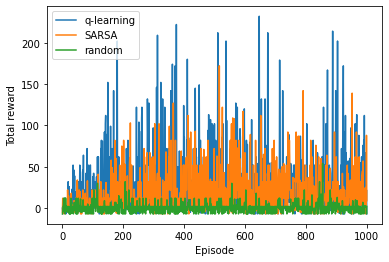

In [68]:
# Compare rewards among agents
fig, ax = plt.subplots()
ax.plot(np.arange(1,num_episodes+1), reward_q_learning, label="q-learning")
ax.plot(np.arange(1,num_episodes+1), reward_sarsa, label="SARSA")
ax.plot(np.arange(1,num_episodes+1), reward_random, label="random")
ax.set_xlabel('Episode')
ax.set_ylabel('Total reward')
ax.legend()
plt.show()

In [70]:
# Convert q-table into state-value dictionary
def get_max_values_dict(input_dict):
    '''Example of how function works
    Input: {(13, -2): {0: 21, 1: 12}, (12, -2): {1: 21, 0: 17}}
    Output: {(13, -2): 21, (12, -2): 21}
    '''
    # create an empty output dictionary
    output_dict = {}
    # loop over each key in the input dictionary
    for key in input_dict.keys():
        # get the maximum value in the inner dictionary
        max_value = max(input_dict[key].values())
        # add the key and maximum value to the output dictionary
        output_dict[key] = max_value
    # return the output dictionary
    return output_dict

state_value_qlearning = get_max_values_dict(q_table_qlearning)
state_value_sarsa = get_max_values_dict(q_table_sarsa)

In [ ]:
# Plot state value function

# create a 2D grid of subplots based on the dictionary keys
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=100)

# loop over each key in the dictionary and create a subplot for it
for key, value in data.items():
    x, y = key
    ax = axs[x][y]
    
    # set the color of the subplot based on the value of the dictionary
    cmap = ListedColormap(['white', 'red'])
    color = cmap(value)
    
    # create a rectangle patch with the specified color and add it to the subplot
    rect = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.add_patch(rect)
    
    # set the axis limits and hide the ticks and labels
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # set the title of the subplot to the key of the dictionary
    ax.set_title(str(key))
    
# set the title of the figure
fig.suptitle('Dictionary Plot')

# show the figure
plt.show()

## **Environment TextFlappyBird-screen-v0**

Some notes on the environment:


*   the environment is displayed on matrix, 2 represent pipeline & 1 represent the bird
*   every step taken, if the bird is alive, the reward = 1



In [50]:
# initiate environment
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
state = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()

    # Appy action and return new state of the environment
    state, reward, done, _, info = env.step(action)
    print("State:")
    print(state)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break
    print("Reward",reward)
    print("-----------------")

env.close()

State:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 0 0 0 0 2 2 2 2 2]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[     